In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import geopandas
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.extra.rate_limiter import RateLimiter
import re
import time
import numpy as np
import pickle
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

/usr/local/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
def city2stores(city):
    store_list = []
    
    URL_city = city.find('a')['href']
    page_city = requests.get(URL_city)
    soup_city = BeautifulSoup(page_city.text, "html.parser")
    
    results_city = soup_city.find(id="contentbegin")
    city_results = results_city.find_all("script", {"type":"application/ld+json"})
    
    for i in range(len(city_results)):
        store_list.append(json.loads("".join(results_city.find_all("script", {"type":"application/ld+json"})[i])))
    
    
    return store_list

In [3]:
def city_geocode(store):
    #take the city url and parse    
    #URL_city = city.find('a')['href']
    #page_city = requests.get(URL_city)
    #soup_city = BeautifulSoup(page_city.text, "html.parser")
    
    #PostalAddress = json.loads("".join(results_city.find("script", {"type":"application/ld+json"})))['address']
    PostalAddress = store['address']
    
    #create the full adress of the store whom you want to geocode, remove single letterrs like (N,S,W,E) and numbers
    street_address = street_address_fix(PostalAddress['streetAddress'])
    address = street_address.split(',')[0] + ', ' + PostalAddress['addressLocality'] + ', ' + PostalAddress['addressRegion'] + ', '+ PostalAddress['addressCountry']

    #geocode using OSM Nominatim
    rnd = np.random.randint(1, 20)
    time.sleep(rnd)
    
    location = locator.geocode(address)
    
    if location is None:
        street_address = re.sub(r'[0-9]+', '', street_address.split(',')[0])
        address = street_address + ', ' + PostalAddress['addressLocality'] + ', ' + PostalAddress['addressRegion'] + ', '+ PostalAddress['addressCountry']
        location = locator.geocode(address)
        
    if location is None:
        street_address = street_abbv_remove(street_address)
        address = street_address + ', ' + PostalAddress['addressLocality'] + ', ' + PostalAddress['addressRegion'] + ', '+ PostalAddress['addressCountry']
        location = locator.geocode(address)
        
    if location is None:
        address = PostalAddress['addressLocality'] + ', ' + PostalAddress['addressRegion'] + ', '+ PostalAddress['addressCountry'] + ', ' + PostalAddress['postalCode']
        location = locator.geocode(address)
        
    try:
        return [dict({'address': location.address, 'lon': location.longitude, 'lat' : location.latitude , 'point' : location.point})]
    except:
        return dict({})


In [4]:
def street_address_fix(StreetAddress):
    replacements = {'RD': 'ROAD',
                    'RD.': 'ROAD',
                    'CIR': 'CIRCLE',
                    'CIR.': 'CIRCLE',
                    'DR': 'DRIVE',
                    'DR.': 'DRIVE',
                    'LN': 'LANE',
                    'LN.': 'LANE',
                    'CT': 'COURT',
                    'CT.': 'COURT',
                    'PL': 'PLACE',
                    'PL.': 'PLACE',
                    'ST': 'STREET',
                    'ST.': 'STREET',
                    'BLVD': 'BOULEVARD',
                    'BLVD.': 'BOULEVARD'}

    StreetAddress = StreetAddress.upper().split()
    
    for i in range(len(StreetAddress)):
        if StreetAddress[i] in replacements.keys():
            StreetAddress[i] = replacements[StreetAddress[i]]
    
    StreetAddress = ' '.join(StreetAddress)
    StreetAddress = ' '.join( [s for s in StreetAddress.split() if len(s)>2] )


    return StreetAddress

In [5]:
def street_abbv_remove(StreetAddress):
    replacements = {'ROAD': ' ',
                    'CIRCLE': ' ',
                    'DRIVE': ' ',
                    'LANE': ' ',
                    'COURT': ' ',
                    'PLACE': ' ',
                    'STREET': ' ',
                    'BOULEVARD': ' '}

    StreetAddress = StreetAddress.upper().split()
    
    for i in range(len(StreetAddress)):
        if StreetAddress[i] in replacements.keys():
            StreetAddress[i] = replacements[StreetAddress[i]]
            
    StreetAddress = ' '.join(StreetAddress)
    StreetAddress = ' '.join( [s for s in StreetAddress.split() if len(s)>2] )


    return StreetAddress

In [6]:
def states2cities(soup):
    cities = []
    results = soup.find(id="contentbegin")
    states = results.find_all("div", class_="itemlist")
    cities.extend([parse_statelinks(states[i]) for i in range(len(states))])
    return cities


In [7]:
def parse_statelinks(states):
    
    URL_state = states.find('a')['href']
    page_state = requests.get(URL_state)

    soup_state = BeautifulSoup(page_state.content, "html.parser")
    results_state = soup_state.find(id="contentbegin")
    cities = results_state.find_all("div", class_="itemlist")
    
    return cities
    

In [317]:
URL = "https://locations.traderjoes.com/"

page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")
geopy.geocoders.options.default_timeout = 25
locator = Nominatim(user_agent="personal_project")


stores = []
states = states2cities(soup)

for j in range(len(states)):
    for i in range(len(states[j])): 
        tmp = city2stores(states[j][i])
        for k in range(len(tmp)):
            a = city_geocode(tmp[k])
            print(a)
            stores.extend(a)
            
            print(j,i,k)
        
#with open('stores.pickle', 'wb') as handle:
    #pickle.dump(stores, handle, protocol=pickle.HIGHEST_PROTOCOL)


[{'address': "Trader Joe's, 205, Summit Boulevard, The Summit, Birmingham, Jefferson County, Alabama, 35243, United States", 'lon': -86.7296304, 'lat': 33.4465102, 'point': Point(33.4465102, -86.7296304, 0.0)}]
0 0 0
[{'address': 'Mid City Drive, Huntsville, Madison County, Alabama, 35814, United States', 'lon': -86.6657541, 'lat': 34.7407671, 'point': Point(34.7407671, -86.6657541, 0.0)}]
0 1 0
[{'address': '11500, Financial Centre Parkway, Little Rock, Pulaski County, Arkansas, 72211, United States', 'lon': -92.40162421894271, 'lat': 34.74820895, 'point': Point(34.74820895, -92.40162421894271, 0.0)}]
1 0 0
[{'address': 'Williams Field High School, 2076, South Higley Road, Gilbert, Maricopa County, Arizona, 85295, United States', 'lon': -111.72369653446924, 'lat': 33.31370025, 'point': Point(33.31370025, -111.72369653446924, 0.0)}]
2 0 0
[{'address': "Trader Joe's, 7720, West Bell Road, Glendale, Maricopa County, Arizona, 85308, United States", 'lon': -112.22651922015237, 'lat': 33.63

KeyboardInterrupt: 

In [81]:
raw_stores = []
#cities = states2cities(soup)

for j in range(len(cities)):
    for i in range(len(cities[j])): 
        tmp = city2stores(cities[j][i])
        raw_stores.extend(tmp)
        print(j,i)

0 0
0 1
1 0
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
3 41
3 42
3 43
3 44
3 45
3 46
3 47
3 48
3 49
3 50
3 51
3 52
3 53
3 54
3 55
3 56
3 57
3 58
3 59
3 60
3 61
3 62
3 63
3 64
3 65
3 66
3 67
3 68
3 69
3 70
3 71
3 72
3 73
3 74
3 75
3 76
3 77
3 78
3 79
3 80
3 81
3 82
3 83
3 84
3 85
3 86
3 87
3 88
3 89
3 90
3 91
3 92
3 93
3 94
3 95
3 96
3 97
3 98
3 99
3 100
3 101
3 102
3 103
3 104
3 105
3 106
3 107
3 108
3 109
3 110
3 111
3 112
3 113
3 114
3 115
3 116
3 117
3 118
3 119
3 120
3 121
3 122
3 123
3 124
3 125
3 126
3 127
3 128
3 129
3 130
3 131
3 132
3 133
3 134
3 135
3 136
3 137
3 138
4 0
4 1
4 2
4 3
4 4
4 5
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
7 0
7 1
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
8 20
8 21
9 0
9 1
9 2
9 3
9 4
9 5
10 0
10 1
11 0
11 1
12 0
12

In [88]:
tj_raw = pd.DataFrame(raw_stores)

In [277]:
tj_raw = tj_raw[['name','url','telephone']]

In [96]:
stores = pd.DataFrame(stores)

In [101]:
stores_gdf = geopandas.GeoDataFrame(stores, geometry=geopandas.points_from_xy(stores.lon, stores.lat))

In [282]:
stores_gdf = stores_gdf.drop(columns=['point'])

In [225]:
city_names_times = []
for j in range(len(cities)):
    for i in range(len(cities[j])): 
        URL_city = cities[j][i].find('a')['href']
        page_city = requests.get(URL_city)
        soup_city = BeautifulSoup(page_city.text, "html.parser")
        results_city = soup_city.find(id="contentbegin")
        city_results = results_city.find_all("script", {"type":"application/ld+json"})
        city_names_times.append(len(city_results))
        print(len(city_results))

1
1
1
1
1
1
1
3
1
1
2
1
2
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
1
1
3
1
11
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
4
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
8
1
6
4
1
1
2
1
1
1
2
1
1
1
2
2
1
1
1
1
1
1
1
1
1
2
1
2
1
2
1
1
1
2
1
1
1
1
1
2
3
1
1
1
1
1
1
1
1
1
1
1
5
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
6
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
2
2
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
3
1
3
1
1
1
1
1
1
1
1
1
1
1
1
10
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
2
3
1
1
1
1
1
1
1
1
1
1
2
3
5
1
3
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
5
1
1
2
1
1
1
1
1


In [238]:
city_names_times

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 11,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 8,
 1,
 6,
 4,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,

In [232]:
city_full = []
for i,j in zip(range(len(city_names)),city_names_times):
    city_full.append(np.repeat(city_names[i],j))

In [233]:
city_full

[array(['Birmingham'], dtype='<U10'),
 array(['Huntsville'], dtype='<U10'),
 array(['Little Rock'], dtype='<U11'),
 array(['Gilbert'], dtype='<U7'),
 array(['Glendale'], dtype='<U8'),
 array(['Mesa'], dtype='<U4'),
 array(['Oro Valley'], dtype='<U10'),
 array(['Phoenix', 'Phoenix', 'Phoenix'], dtype='<U7'),
 array(['Prescott'], dtype='<U8'),
 array(['Queen Creek'], dtype='<U11'),
 array(['Scottsdale', 'Scottsdale'], dtype='<U10'),
 array(['Surprise'], dtype='<U8'),
 array(['Tempe', 'Tempe'], dtype='<U5'),
 array(['Tucson', 'Tucson', 'Tucson'], dtype='<U6'),
 array(['Agoura Hills'], dtype='<U12'),
 array(['Alameda'], dtype='<U7'),
 array(['Aliso Viejo'], dtype='<U11'),
 array(['Arroyo Grande'], dtype='<U13'),
 array(['Bakersfield'], dtype='<U11'),
 array(['Berkeley'], dtype='<U8'),
 array(['Brea'], dtype='<U4'),
 array(['Brentwood'], dtype='<U9'),
 array(['Burbank'], dtype='<U7'),
 array(['Calabasas'], dtype='<U9'),
 array(['Camarillo'], dtype='<U9'),
 array(['Campbell'], dtype='<U8'),


In [234]:
city_f = []
for i in range(len(city_full)):
    for j in range(len(city_full[i])):
        city_f.append(city_full[i][j])

In [237]:
city_f

['Birmingham',
 'Huntsville',
 'Little Rock',
 'Gilbert',
 'Glendale',
 'Mesa',
 'Oro Valley',
 'Phoenix',
 'Phoenix',
 'Phoenix',
 'Prescott',
 'Queen Creek',
 'Scottsdale',
 'Scottsdale',
 'Surprise',
 'Tempe',
 'Tempe',
 'Tucson',
 'Tucson',
 'Tucson',
 'Agoura Hills',
 'Alameda',
 'Aliso Viejo',
 'Arroyo Grande',
 'Bakersfield',
 'Berkeley',
 'Brea',
 'Brentwood',
 'Burbank',
 'Calabasas',
 'Camarillo',
 'Campbell',
 'Capitola',
 'Carlsbad',
 'Castro Valley',
 'Cathedral City',
 'Cerritos',
 'Chatsworth',
 'Chico',
 'Chino Hills',
 'Chula Vista',
 'Claremont',
 'Clovis',
 'Concord',
 'Concord',
 'Corona',
 'Costa Mesa',
 'Culver City',
 'Culver City',
 'Daly City',
 'Danville',
 'Davis',
 'Eagle Rock',
 'El Cerrito',
 'Elk Grove',
 'Emeryville',
 'Encinitas',
 'Encino',
 'Escondido',
 'Fairfield',
 'Fair Oaks',
 'Folsom',
 'Fremont',
 'Fresno',
 'Glendale',
 'Goleta',
 'Granada Hills',
 'Greenbrae',
 'Hermosa Beach',
 'Huntington Beach',
 'Huntington Beach',
 'Huntington Beach',
 '

In [248]:
state_full = []
for i,j in zip(range(len(st)),city_names_times):
    state_full.append(np.repeat(st[i],j))

In [250]:
state_f = []
for i in range(len(state_full)):
    for j in range(len(state_full[i])):
        state_f.append(state_full[i][j])

In [266]:
d = {'city': city_f, 'state': state_f}

A = pd.DataFrame(d)

In [270]:
rnd = np.random.randint(1, len(A))

A.iloc[rnd]

city         Arlington
state    Massachusetts
Name: 303, dtype: object

In [284]:
TJ = pd.concat([stores_gdf,A,tj_raw],axis=1)

In [295]:
TJ.columns = ['Address', 'Longitude', 'Latitude', 'Geometry', 'City', 'State', 'StoreName', 'Url',
       'Tel']

In [297]:
TJ = TJ[['StoreName','City','State','Longitude','Latitude','Geometry','Address','Tel','Url']]

In [298]:
TJ

,StoreName,City,State,Longitude,Latitude,Geometry,Address,Tel,Url
0,Trader Joe's Birmingham (737),Birmingham,Alabama,-86.729630,33.446510,POINT (-86.72963 33.44651),"Trader Joe's, 205, Summit Boulevard, The Summi...",205-969-7801,https://locations.traderjoes.com/al/birmingham/
1,Trader Joe's Huntsville (785),Huntsville,Alabama,-86.665754,34.740767,POINT (-86.66575 34.74077),"Mid City Drive, Huntsville, Madison County, Al...",256-890-7156,https://locations.traderjoes.com/al/huntsville/
2,Trader Joe's Little Rock (756),Little Rock,Arkansas,-92.401624,34.748209,POINT (-92.40162 34.74821),"11500, Financial Centre Parkway, Little Rock, ...",501-954-7659,https://locations.traderjoes.com/ar/little-rock/
3,Trader Joe's Gilbert (Santan) (285),Gilbert,Arizona,-111.723697,33.313700,POINT (-111.72370 33.31370),"Williams Field High School, 2076, South Higley...",480-857-9878,https://locations.traderjoes.com/az/gilbert/
4,Trader Joe's Glendale (85),Glendale,Arizona,-112.226519,33.639293,POINT (-112.22652 33.63929),"Trader Joe's, 7720, West Bell Road, Glendale, ...",623-776-7414,https://locations.traderjoes.com/az/glendale/
...,...,...,...,...,...,...,...,...,...
534,Trader Joe's University Place (148),University Place,Washington,-122.538459,47.223082,POINT (-122.53846 47.22308),"The UPS Store, 3800, Bridgeport Way West, Brid...",253-460-2672,https://locations.traderjoes.com/wa/university...
535,Trader Joe's Vancouver (136),Vancouver,Washington,-122.554407,45.618800,POINT (-122.55441 45.61880),"Nekter Juice Bar, 305, Southeast Chkalov Drive...",360-883-9000,https://locations.traderjoes.com/wa/vancouver/
536,Trader Joe's Brookfield (726),Brookfield,Wisconsin,-88.070104,43.035660,POINT (-88.07010 43.03566),"Trader Joe's, 12665, West Bluemound Road, Broo...",262-784-4806,https://locations.traderjoes.com/wi/brookfield/
537,Trader Joe's Madison (712),Madison,Wisconsin,-89.417285,43.064994,POINT (-89.41728 43.06499),"Trader Joe's, 1810, Monroe Street, Oakland Hei...",608-257-1916,https://locations.traderjoes.com/wi/madison/


In [300]:
TJ.to_csv("/Users/yigitalp/Documents/TJ.csv",index=False)

In [302]:
pd.read_csv("/Users/yigitalp/Documents/TJ.csv")

,StoreName,City,State,Longitude,Latitude,Geometry,Address,Tel,Url
0,Trader Joe's Birmingham (737),Birmingham,Alabama,-86.729630,33.446510,POINT (-86.7296304 33.4465102),"Trader Joe's, 205, Summit Boulevard, The Summi...",205-969-7801,https://locations.traderjoes.com/al/birmingham/
1,Trader Joe's Huntsville (785),Huntsville,Alabama,-86.665754,34.740767,POINT (-86.6657541 34.7407671),"Mid City Drive, Huntsville, Madison County, Al...",256-890-7156,https://locations.traderjoes.com/al/huntsville/
2,Trader Joe's Little Rock (756),Little Rock,Arkansas,-92.401624,34.748209,POINT (-92.40162421894271 34.74820895),"11500, Financial Centre Parkway, Little Rock, ...",501-954-7659,https://locations.traderjoes.com/ar/little-rock/
3,Trader Joe's Gilbert (Santan) (285),Gilbert,Arizona,-111.723697,33.313700,POINT (-111.7236965344692 33.31370025),"Williams Field High School, 2076, South Higley...",480-857-9878,https://locations.traderjoes.com/az/gilbert/
4,Trader Joe's Glendale (85),Glendale,Arizona,-112.226519,33.639293,POINT (-112.2265192201524 33.63929255),"Trader Joe's, 7720, West Bell Road, Glendale, ...",623-776-7414,https://locations.traderjoes.com/az/glendale/
...,...,...,...,...,...,...,...,...,...
534,Trader Joe's University Place (148),University Place,Washington,-122.538459,47.223082,POINT (-122.5384585723828 47.22308225),"The UPS Store, 3800, Bridgeport Way West, Brid...",253-460-2672,https://locations.traderjoes.com/wa/university...
535,Trader Joe's Vancouver (136),Vancouver,Washington,-122.554407,45.618800,POINT (-122.5544069 45.6188004),"Nekter Juice Bar, 305, Southeast Chkalov Drive...",360-883-9000,https://locations.traderjoes.com/wa/vancouver/
536,Trader Joe's Brookfield (726),Brookfield,Wisconsin,-88.070104,43.035660,POINT (-88.07010414809744 43.0356596),"Trader Joe's, 12665, West Bluemound Road, Broo...",262-784-4806,https://locations.traderjoes.com/wi/brookfield/
537,Trader Joe's Madison (712),Madison,Wisconsin,-89.417285,43.064994,POINT (-89.4172848 43.0649945),"Trader Joe's, 1810, Monroe Street, Oakland Hei...",608-257-1916,https://locations.traderjoes.com/wi/madison/


In [223]:
city_results = results_city.find_all("script", {"type":"application/ld+json"})
len(city_results)

1

In [207]:
URL_city = cities[j][i].find('a')['href']
page_city = requests.get(URL_city)
soup_city = BeautifulSoup(page_city.text, "html.parser")
results_city = soup_city.find(id="contentbegin")
len(results_city)

3

In [ ]:
URL_city = city.find('a')['href']
    page_city = requests.get(URL_city)
    soup_city = BeautifulSoup(page_city.text, "html.parser")
    
    results_city = soup_city.find(id="contentbegin")
    city_results = results_city.find_all("script", {"type":"application/ld+json"})

In [194]:
ccc

['Birmingham',
 'Huntsville',
 'Little Rock',
 'Gilbert',
 'Glendale',
 'Mesa',
 'Oro Valley',
 'Phoenix',
 'Prescott',
 'Queen Creek',
 'Scottsdale',
 'Surprise',
 'Tempe',
 'Tucson',
 'Agoura Hills',
 'Alameda',
 'Aliso Viejo',
 'Arroyo Grande',
 'Bakersfield',
 'Berkeley',
 'Brea',
 'Brentwood',
 'Burbank',
 'Calabasas',
 'Camarillo',
 'Campbell',
 'Capitola',
 'Carlsbad',
 'Castro Valley',
 'Cathedral City',
 'Cerritos',
 'Chatsworth',
 'Chico',
 'Chino Hills',
 'Chula Vista',
 'Claremont',
 'Clovis',
 'Concord',
 'Corona',
 'Costa Mesa',
 'Culver City',
 'Daly City',
 'Danville',
 'Davis',
 'Eagle Rock',
 'El Cerrito',
 'Elk Grove',
 'Emeryville',
 'Encinitas',
 'Encino',
 'Escondido',
 'Fairfield',
 'Fair Oaks',
 'Folsom',
 'Fremont',
 'Fresno',
 'Glendale',
 'Goleta',
 'Granada Hills',
 'Greenbrae',
 'Hermosa Beach',
 'Huntington Beach',
 'Irvine',
 'La Canada',
 'Lafayette',
 'Laguna Hills',
 'Laguna Niguel',
 'La Habra',
 'La Jolla',
 'La Mesa',
 'La Quinta',
 'Livermore',
 'L

In [134]:
stores

,address,lon,lat,point,geometry
0,"Trader Joe's, 205, Summit Boulevard, The Summi...",-86.729630,33.446510,"33 26m 47.4367s N, 86 43m 46.6694s W",POINT (-86.72963 33.44651)
1,"Mid City Drive, Huntsville, Madison County, Al...",-86.665754,34.740767,"34 44m 26.7616s N, 86 39m 56.7148s W",POINT (-86.66575 34.74077)
2,"11500, Financial Centre Parkway, Little Rock, ...",-92.401624,34.748209,"34 44m 53.5522s N, 92 24m 5.84719s W",POINT (-92.40162 34.74821)
3,"Williams Field High School, 2076, South Higley...",-111.723697,33.313700,"33 18m 49.3209s N, 111 43m 25.3075s W",POINT (-111.72370 33.31370)
4,"Trader Joe's, 7720, West Bell Road, Glendale, ...",-112.226519,33.639293,"33 38m 21.4532s N, 112 13m 35.4692s W",POINT (-112.22652 33.63929)
...,...,...,...,...,...
534,"The UPS Store, 3800, Bridgeport Way West, Brid...",-122.538459,47.223082,"47 13m 23.0961s N, 122 32m 18.4509s W",POINT (-122.53846 47.22308)
535,"Nekter Juice Bar, 305, Southeast Chkalov Drive...",-122.554407,45.618800,"45 37m 7.68144s N, 122 33m 15.8648s W",POINT (-122.55441 45.61880)
536,"Trader Joe's, 12665, West Bluemound Road, Broo...",-88.070104,43.035660,"43 2m 8.37456s N, 88 4m 12.3749s W",POINT (-88.07010 43.03566)
537,"Trader Joe's, 1810, Monroe Street, Oakland Hei...",-89.417285,43.064994,"43 3m 53.9802s N, 89 25m 2.22528s W",POINT (-89.41728 43.06499)


In [124]:
state = []
for j in range(len(states)):
    for i in range(len(cities[j])): 
        tmp = cities[j][i].text
        city.extend(tmp)
        print(tmp)

In [151]:
state_name = []
for j in range(len(states)):
    state_name.append(states[j].text.replace('\n',""))


In [245]:
len(st)

424

In [171]:
l = []
for i,j in zip(range(len(state_name)),c):
    l.append(np.repeat(state_name[i],j))

In [179]:
st = []
for i in range(len(l)):
    for j in range(len(l[i])):
        st.append(l[i][j])

In [181]:
len(st)

424

In [148]:
c = []
for i in range(len(states)):
    URL_state = states[i].find('a')['href']
    page_state = requests.get(URL_state)
    soup_state = BeautifulSoup(page_state.content, "html.parser")
    results_state = soup_state.find(id="contentbegin")
    k = results_state.find_all("div", class_="itemlist")
    URL_city = city.find('a')['href']
    page_city = requests.get(URL_city)
    soup_city = BeautifulSoup(page_city.text, "html.parser")
    
    results_city = soup_city.find(id="contentbegin")
    city_results = results_city.find_all("script", {"type":"application/ld+json"})

    c.append(len(k))

In [196]:
k

[<div class="itemlist"><a class="ga_w2gi_lp listitem" data-gaact="Click_to_CityPage" data-galoc="City Level - Brookfield" data-linktrack="City index page - Brookfield" href="https://locations.traderjoes.com/wi/brookfield/" style="font-size: 16px;">Brookfield</a></div>,
 <div class="itemlist"><a class="ga_w2gi_lp listitem" data-gaact="Click_to_CityPage" data-galoc="City Level - Madison" data-linktrack="City index page - Madison" href="https://locations.traderjoes.com/wi/madison/" style="font-size: 16px;">Madison</a></div>,
 <div class="itemlist"><a class="ga_w2gi_lp listitem" data-gaact="Click_to_CityPage" data-galoc="City Level - Milwaukee" data-linktrack="City index page - Milwaukee" href="https://locations.traderjoes.com/wi/milwaukee/" style="font-size: 16px;">Milwaukee</a></div>]

In [136]:
c=[]
c.extend([parse_statelinks(states[i]) for i in range(len(states))])


### Small fix with one address

In [10]:
with open(r"stores.pickle", "rb") as input_file:
    stores= pickle.load(input_file)

stores_data = pd.DataFrame(stores)

address = stores_data[stores_data.lon==stores_data.lon.max()].address
locator = Nominatim(user_agent="personal_project")

stores[384]['address'] = locator.geocode('77 Boston Turnpike, Shrewsbury, MA,USA').address
stores[384]['lon'] =locator.geocode('77 Boston Turnpike, Shrewsbury, MA,USA').longitude
stores[384]['lat'] = locator.geocode('77 Boston Turnpike, Shrewsbury, MA,USA').latitude
stores[384]['point'] = locator.geocode('77 Boston Turnpike, Shrewsbury, MA,USA').point

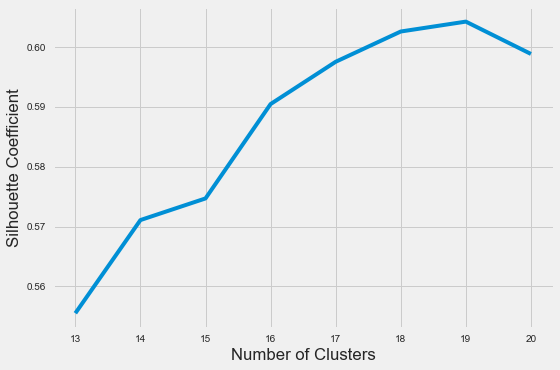

In [250]:
#Silhuette
from sklearn.metrics import silhouette_samples, silhouette_score
silhouette_coefficients = []
for k in range(13, 21):
    
    kmeans = KMeans(
    init="random",
    n_clusters=k,
    n_init=10,
    max_iter=100,
    random_state=17)
    
    kmeans.fit(coordinates)
    score = silhouette_score(coordinates, kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.style.use("fivethirtyeight")
plt.plot(range(13, 21), silhouette_coefficients)
plt.xticks(range(13, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [14]:
#Ground Truths
warehouse_address = ['Nazareth, PA 18064, USA', 'Suwanee, GA 30024, USA', '30 Commerce Blvd, Middleborough, MA , USA',
                    'Minooka 60447, IL, USA','5111 Bear Creek Ct, Irving, TX 75061, USA','2388 Mason Ave, Daytona Beach, FL 32117, USA',
                    '200 Phoenix Xing, Bloomfield, CT 06002, USA','10288 Calabash Ave, Fontana, CA 92335, USA','2121 Boeing Way, Stockton, CA 95206, USA',
                    '3707 Hogum Bay Rd NE, Lacey, WA 9851','4681 Edison Ave, Chino, CA 91710, USA','10401 W Van Buren St, Tolleson, AZ 85353, USA']

def real_warehouse_address(rwa):
    
    adrs = locator.geocode(rwa)
    return [dict({'address': adrs.address, 'lon': adrs.longitude, 'lat' : adrs.latitude , 'point' : adrs.point})]

    
rwa = []
for adrs in warehouse_address:
    rwa.append(real_warehouse_address(adrs))


## Analysis Part

In [91]:
with open(r"stores.pickle", "rb") as input_file:
    stores= pickle.load(input_file)

In [245]:
rnd = np.random.randint(1, 1000)

stores_data = pd.DataFrame(stores)
coordinates = stores_data[['lon','lat']].values

#standardize? or Not
#scaler = StandardScaler()
#scaled_coordinates = scaler.fit_transform(coordinates)

kmeans = KMeans(
    init="k-means++",
    n_clusters=19,
    n_init=10,
    max_iter=100, random_state=rnd)
kmeans.fit(coordinates)

kmeans.cluster_centers_
#warehouse_array = scaler.inverse_transform(kmeans.cluster_centers_)
#warehouse = pd.DataFrame(warehouse_array, columns = ['lon','lat'])
warehouse = pd.DataFrame(kmeans.cluster_centers_, columns = ['lon','lat'])
labels = pd.DataFrame(kmeans.labels_, columns= ['labels'])
stores_data = pd.concat([stores_data,labels], axis = 1 ) 
stores_data['labels'] = stores_data['labels'].astype(str)

m = folium.Map(location=[37, -102], zoom_start=4, tiles="cartodbpositron")

stores_data.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["lon"]], 
                                              radius=2, fill_color = "black", color='darkorange',fill=True)
                                             .add_to(m), axis=1)




    
    
for w in range(len(warehouse)):

    folium.CircleMarker(
        location=[warehouse.iloc[w]['lat'],warehouse.iloc[w]['lon']],
        radius=5,
        popup="Laurelhurst Park",
        color="darkred",
        fill=True,
        fill_color="darkred",
    ).add_to(m)
    
for j in stores_data.labels.unique():
    temp = stores_data[stores_data.labels==j]
    for i in range(len(temp)):
        folium.PolyLine([(warehouse.loc[int(j)].lat,warehouse.loc[int(j)].lon),(temp.iloc[i].lat,temp.iloc[i].lon)],
                        color='black',
                        weight=1,
                        opacity=0.6).add_to(m)    
        

        
for k in range(len(rwa)):   
    
    folium.CircleMarker(
        location=[rwa[k][0]['lat'],rwa[k][0]['lon']],
        radius=5,
        color="green",
        fill=True,
        fill_color="green",
        opacity = 1
    ).add_to(m)


m


In [315]:
rnd = np.random.randint(1, 1000)

stores_data = pd.DataFrame(stores)
coordinates = stores_data[['lon','lat']].values

#standardize? or Not
#scaler = StandardScaler()
#scaled_coordinates = scaler.fit_transform(coordinates)

kmeans = KMeans(
    init="k-means++",
    n_clusters=19,
    n_init=10,
    max_iter=100, random_state=rnd)
kmeans.fit(coordinates)

kmeans.cluster_centers_
#warehouse_array = scaler.inverse_transform(kmeans.cluster_centers_)
#warehouse = pd.DataFrame(warehouse_array, columns = ['lon','lat'])
warehouse = pd.DataFrame(kmeans.cluster_centers_, columns = ['lon','lat'])
labels = pd.DataFrame(kmeans.labels_, columns= ['labels'])
stores_data = pd.concat([stores_data,labels], axis = 1 ) 
stores_data['labels'] = stores_data['labels'].astype(str)

m = folium.Map(location=[37, -102], zoom_start=4)

stores_data.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["lon"]], 
                                              radius=1.5, color='steelblue')
                                             .add_to(m), axis=1)



m